# Introduction
Self-supervised monocular depth estimation (SDE, or unsupervised monocular depth estimation) is a framework that uses information from two adjacent cameras (e.g., stereo cameras) or two consecutive frames in a video to supervise depth estimation networks. The great thing about SDE is that it does not require any ground truth depth to learn the depth, just stereo images or videos!



>[1] Garg, Ravi, et al. "Unsupervised cnn for single view depth estimation: Geometry to the rescue." Computer Vision–ECCV 2016: 14th European Conference, Amsterdam, The Netherlands, October 11-14, 2016, Proceedings, Part VIII 14. Springer International Publishing, 2016.

>[2] Zhou, Tinghui, et al. "Unsupervised learning of depth and ego-motion from video." Proceedings of the IEEE conference on computer vision and pattern recognition. 2017.

# Downloading the dataset
We use *Optical Flow* dataset from the well-known [kitti dataset](https://www.cvlibs.net/datasets/kitti/eval_scene_flow.php?benchmark=flow) for this project.

In [1]:
# Download the dataset
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_scene_flow.zip

--2024-09-23 07:16:37--  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_scene_flow.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 3.5.138.151, 3.5.135.2, 52.219.171.177, ...
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|3.5.138.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1681488619 (1.6G) [application/zip]
Saving to: 'data_scene_flow.zip'

data_scene_flow.zip 100%[===================>]   1.57G  9.58MB/s    in 98s     

2024-09-23 07:18:16 (16.3 MB/s) - 'data_scene_flow.zip' saved [1681488619/1681488619]



In [2]:
# unizp the data
!unzip -q data_scene_flow.zip

## A note about using custom data:
You can use any other stereo dataset or even your custom dataset to run this code. All you need is two calibrated stereo cameras.

# The PyTorch Dataset

A dataset class in pytorch format. It returns a dictionary containing the left and right images and corresponding camera intrinsics and extrinsics.


In [3]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image

class KittiDataset(Dataset):
    def __init__(self, root_dir='training', image_size=224):
        """
        Args:
            root_dir (string): Directory with all the images.
            image_size (int, optional): The size of the image used to train the model.
                All images will be resized to squares with this size.
        """
        self.root_dir = root_dir
        # Define the transformation to resize images and convert them to tensors
        self.data_transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
        ])

        self.left_img_list = []
        self.right_img_list = []

        # Scan the file paths for left images
        left_img_dir = os.path.join(root_dir, 'image_2')
        for img_name in os.listdir(left_img_dir):
            self.left_img_list.append(os.path.join(left_img_dir, img_name))

        # Scan the file paths for right images
        right_img_dir = os.path.join(root_dir, 'image_3')
        for img_name in os.listdir(right_img_dir):
            self.right_img_list.append(os.path.join(right_img_dir, img_name))

        # Ensure the number of left and right images are the same
        assert len(self.left_img_list) == len(self.right_img_list)

        self.iterator = 0

        # Intrinsic camera matrix (normalized) of the kitti dataset
        self.K = np.array([[0.58, 0, 0.5, 0],
                           [0, 1.92, 0.5, 0],
                           [0, 0, 1, 0],
                           [0, 0, 0, 1]], dtype=np.float32)


        # Define the stereo transformation matrix
        self.K[0, 0] *= image_size
        self.K[1, 1] *= image_size
        self.K[0, 2] *= image_size
        self.K[1, 2] *= image_size

        self.stereo_T = np.eye(4, dtype=np.float32)
        self.stereo_T[0, 3] = -0.1


    def __len__(self):
        # Return the total number of image pairs
        return len(self.left_img_list)

    def __getitem__(self, idx):
        # Load the left and right images
        img_left = Image.open(self.left_img_list[idx])
        img_right = Image.open(self.right_img_list[idx])

        # Apply the transformations to the images
        img_left = self.data_transform(img_left)
        img_right = self.data_transform(img_right)



        # Create a sample dictionary containing the images and transformation matrices
        sample = {'img_left': img_left,
                  'img_right': img_right,
                  'stereo_T': torch.from_numpy(self.stereo_T),
                  'K': torch.from_numpy(self.K),
                  'inv_K': torch.from_numpy(np.linalg.pinv(self.K))
                  }

        return sample

## Define Torch data loader
Torch data loaders are wrapper classes for datasets that return the dataset outputs in batched format.

In [4]:
# Create the dataset
dataset = KittiDataset(root_dir='training')

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=6, shuffle=True, drop_last=True)

## Check the Dataset
Just to verify everything is okay.

Each batch consists of: {
img_left: torch.Size([6, 3, 224, 224])
img_right: torch.Size([6, 3, 224, 224])
stereo_T: torch.Size([6, 4, 4])
K: torch.Size([6, 4, 4])
inv_K: torch.Size([6, 4, 4])
}


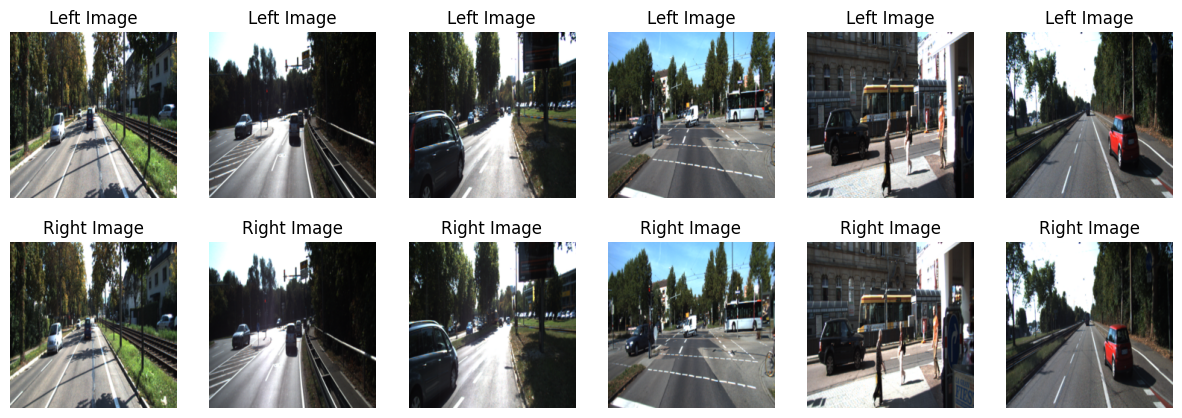

In [5]:
import matplotlib.pyplot as plt

# Function to visualize images
def show_images(batch):
    fig, axes = plt.subplots(2, len(batch['img_left']), figsize=(15, 5))
    for i in range(len(batch['img_left'])):
        img_left = batch['img_left'][i].permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
        img_right = batch['img_right'][i].permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)

        axes[0, i].imshow(img_left)
        axes[0, i].set_title('Left Image')
        axes[0, i].axis('off')

        axes[1, i].imshow(img_right)
        axes[1, i].set_title('Right Image')
        axes[1, i].axis('off')
    plt.show()

# Get a batch of data
for batch in dataloader:
    print('Each batch consists of: {')
    for key, value in batch.items():
      print(f'{key}: {value.shape}')
    print('}')
    show_images(batch)
    break  # Only show one batch

# Define Model

For the neural network that predicts depth, we can use any encoder-decoder architecture. Academic works on SDE usually have their own special architecture, which produces better results. They also usually produce multi-scale outputs and define loss on each scale separately. Here, we are going to use a simple off-the-shelf UNet.


## Install U-Net
The backboned-unit repository on GitHub provides the U-Net architecture
with various pre-trained encoders.

In [6]:
!git clone https://github.com/mkisantal/backboned-unet.git
!pip install -q ./backboned-unet

Cloning into 'backboned-unet'...
remote: Enumerating objects: 84, done.
remote: Total 84 (delta 0), reused 0 (delta 0), pack-reused 84 (from 1)
Unpacking objects: 100% (84/84), 1.46 MiB | 12.27 MiB/s, done.


## Initiate a U-Net instance and check the input-output

Let's import the installed U-Net and create an instance with ResNet18 as the backbone. We have chosen the number of classes to be one because depth estimation is a regression problem. I received one batch from the data loader and passed it through the model to ensure everything was correct.

In [7]:
from backboned_unet import Unet
model = Unet(backbone_name='resnet18', classes=1)


for batch in dataloader:
  # Perform inference
  with torch.no_grad():
      input = batch['img_left']
      output = model(input)
  print(f'input to the model: {input.shape}')
  print(f'output of the model: {output.shape}')
  break


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 157MB/s]


upsample_blocks[0] in: 512   out: 256
upsample_blocks[1] in: 256   out: 128
upsample_blocks[2] in: 128   out: 64
upsample_blocks[3] in: 64   out: 32
upsample_blocks[4] in: 32   out: 16
input to the model: torch.Size([6, 3, 224, 224])
output of the model: torch.Size([6, 1, 224, 224])


# Image Reconstruction as supervision
Here comes the hard part!
 Let's designate the left image in a stereo pair as $I_t$ (t for target) and the right one as $I_s$ (s for source). If the predicted depth for the left image, denoted as $\hat{D}_t$, is accurate, we can reconstruct the left image using $\hat{D}_t$ and $I_s$. Let's represent this reconstructed image as $\hat{I}_s$. To create $\hat{I}_s$, we must map each pixel location $p_t$ from the left image to the corresponding location on the right image, denoted as $p_s$. The relationship between $p_s$ and $p_t$ can be expressed as:

$p_s \sim K T_{t \rightarrow s} \hat{D}_t(p_t) K^{-1} p_t$

Here, $\hat{D}_t(p_t)$ represents the depth of the point $p_t$, and $K$ and $T_{t \rightarrow s}$ denote the camera's intrinsic parameters and the transformation between the two cameras, respectively.

Having $p_s$, we can use the color value from $I_s$ at this location and place it in $\hat{I}_s$ to reconstruct the left image. This process is depicted in the figure below:

* Note that $p_s$ could be a decimal value, so we use interpolation from 4 surrounding pixels to get the value at $p_s$.



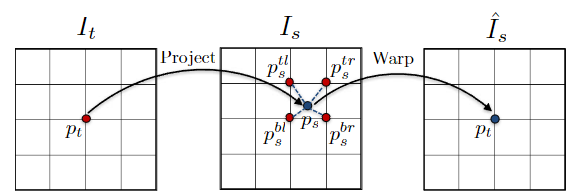



## Projection Classes

The equation $p_s \sim K T_{t \rightarrow s} \hat{D}_t(p_t) K^{-1} p_t$ (The arrow marked as "Project" on the above figure) consists of two parts. The first part, $\hat{D}_t(p_t) K^{-1} p_t$, converts the picture coordinates from the left image to a 3D point cloud. The second part, $K T_{t \rightarrow s}$, maps this point cloud to the picture coordinates of the right camera.

Here, we have two classes for handling these two parts.

In [8]:
import torch.nn as nn

class BackprojectDepth(nn.Module):
    """Layer to transform a depth image into a point cloud"""
    def __init__(self, batch_size, height, width):
        super(BackprojectDepth, self).__init__()

        self.batch_size = batch_size
        self.height = height
        self.width = width

        # Create a meshgrid of pixel coordinates
        meshgrid = np.meshgrid(range(self.width), range(self.height), indexing='xy')
        self.id_coords = np.stack(meshgrid, axis=0).astype(np.float32)
        self.id_coords = nn.Parameter(torch.from_numpy(self.id_coords), requires_grad=False)

        # Create a tensor of ones for homogeneous coordinates
        self.ones = nn.Parameter(torch.ones(self.batch_size, 1, self.height * self.width), requires_grad=False)

        # Stack pixel coordinates and ones to form homogeneous pixel coordinates
        self.pix_coords = torch.unsqueeze(torch.stack(
            [self.id_coords[0].view(-1), self.id_coords[1].view(-1)], 0), 0)
        self.pix_coords = self.pix_coords.repeat(batch_size, 1, 1)
        self.pix_coords = nn.Parameter(torch.cat([self.pix_coords, self.ones], 1), requires_grad=False)

    def forward(self, depth, inv_K):
        # Transform pixel coordinates to camera coordinates
        cam_points = torch.matmul(inv_K[:, :3, :3], self.pix_coords)
        cam_points = depth.view(self.batch_size, 1, -1) * cam_points
        cam_points = torch.cat([cam_points, self.ones], 1)

        return cam_points


class Project3D(nn.Module):
    """Layer which projects 3D points into a camera with intrinsics K and at position T"""
    def __init__(self, batch_size, height, width, eps=1e-7):
        super(Project3D, self).__init__()

        self.batch_size = batch_size
        self.height = height
        self.width = width
        self.eps = eps

    def forward(self, points, K, T):

        projection_matrix = K @ T
        cam_points = projection_matrix @ points


        # Normalize pixel coordinates
        pix_coords = cam_points[:, :2, :] / (cam_points[:, 2, :].unsqueeze(1) + self.eps)
        pix_coords = pix_coords.view(self.batch_size, 2, self.height, self.width)
        pix_coords = pix_coords.permute(0, 2, 3, 1)
        pix_coords[..., 0] /= self.width - 1
        pix_coords[..., 1] /= self.height - 1
        pix_coords = (pix_coords - 0.5) * 2

        return pix_coords

## Image Reconstruction Classe
Having the two classes above, we can reconstruct the left image by warping the right image. ($\hat{I}_s$ in the figure above). The following class will handle that task for us.

In [9]:
class WarpImage(nn.Module):
    def __init__(self, batch_size, height, width):
        super(WarpImage, self).__init__()
        # Initialize backprojection and projection modules
        self.backproject_depth = BackprojectDepth(batch_size, height, width)
        self.project_3d = Project3D(batch_size, height, width)

    def forward(self, inputs, depth):
        # Get the transformation matrix from inputs
        T = inputs["stereo_T"]

        # Backproject depth map to 3D camera points
        cam_points = self.backproject_depth(depth, inputs["inv_K"])

        # Project 3D camera points to 2D pixel coordinates
        pix_coords = self.project_3d(cam_points, inputs["K"], T)

        warped_image = torch.nn.functional.grid_sample(inputs["img_right"], pix_coords, mode='bilinear', padding_mode='border')

        return warped_image

# The loss function
Again, if our depth estimation network works correctly, we expect that the two images $I_t$ and $\hat{I}_s$ (which is calculated with $\hat{D}_t$) to be **ideally** the same images. So, the difference between these two images is our loss function!

Recent works on SDE use different loss functions to measure "the difference" between the two images, but almost all of them have a combination of SSIM and MAE loss.
$loss={\alpha}\left(1-\operatorname{SSIMLoss}\left(I_t, \hat{I}_s\right)\right)+(1-\alpha)\left\|I_t-\hat{I}_s\right\|$

$\alpha$ is a hyperparameter for the balance between the two losses.

Another loss function, "smoothness loss," helps produce high-quality depth. This function ensures that the edges of the input image and the predicted depth are in the same locations, as we would expect in the real world. (See references for more information about this.)
)
$L_s=\left|\partial_x d_t^*\right| e^{-\left|\partial_x I_t\right|}+\left|\partial_y d_t^*\right| e^{-\left|\partial_y I_t\right|}$


So our final loss function is:

$loss={\alpha}\left(1-\operatorname{SSIMLoss}\left(I_t, \hat{I}_s\right)\right)+(1-\alpha)\left\|I_t-\hat{I}_s\right\| + {\beta}L_s$


## Define the loss function

In [10]:
pip install -q kornia

Note: you may need to restart the kernel to use updated packages.


In [11]:
from kornia.losses import inverse_depth_smoothness_loss, ssim_loss
from torch.nn.functional import l1_loss

# The train loop

In [12]:
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move the model to GPU
model.to(device)

# Initialize the warp image module and move it to GPU
warp_image = WarpImage(batch_size=6, height=224, width=224)
warp_image.to(device)

# Use a lower learning rate to start with
optimizer = torch.optim.Adam([
    {'params': model.get_pretrained_parameters(), 'lr': 5e-4},
    {'params': model.get_random_initialized_parameters()}
], lr=1e-2)

# Define loss weights
smoothness_weight = 0.001
ssim_weight = 0.85
photometric_weight = 0.15

# Training loop
for epoch in range(70):
    model.train()
    running_loss = 0.0

    # Iterate over batches
    for i, batch in enumerate(dataloader, 0):
        # Move batch data to GPU
        for key, value in batch.items():
            batch[key] = value.to(device)

        img_left, img_right = batch['img_left'], batch['img_right']

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        depth = F.relu(model(img_left))
        left_warped = warp_image(batch, depth)

        photometric_loss = l1_loss(img_left, left_warped)
        smoothness_loss_value = inverse_depth_smoothness_loss(depth, img_left)
        ssim_loss_value = 2 * ssim_loss(img_left, left_warped, 11)

        # Total loss
        loss = (smoothness_weight * smoothness_loss_value +
                ssim_weight * ssim_loss_value +
                photometric_weight * photometric_loss)

        # Backward pass and optimization
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()

    # Print epoch loss
    print(f'epoch: [{epoch + 1}] loss: {running_loss / i:.3f}')
    running_loss = 0.0

    # Adjust the learning rate
    # Save model checkpoint
    torch.save(model.state_dict(), f'checkpoint_epoch_{epoch + 1}.pth')

print('Finished Training')

2024-09-23 07:19:14.372688: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-23 07:19:14.372793: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-23 07:19:14.516883: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:4296: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


epoch: [1] loss: 0.590
epoch: [2] loss: 0.359
epoch: [3] loss: 0.246
epoch: [4] loss: 0.203
epoch: [5] loss: 0.192
epoch: [6] loss: 0.180
epoch: [7] loss: 0.172
epoch: [8] loss: 0.161
epoch: [9] loss: 0.157
epoch: [10] loss: 0.148
epoch: [11] loss: 0.146
epoch: [12] loss: 0.143
epoch: [13] loss: 0.136
epoch: [14] loss: 0.134
epoch: [15] loss: 0.131
epoch: [16] loss: 0.128
epoch: [17] loss: 0.127
epoch: [18] loss: 0.124
epoch: [19] loss: 0.121
epoch: [20] loss: 0.122
epoch: [21] loss: 0.118
epoch: [22] loss: 0.120
epoch: [23] loss: 0.118
epoch: [24] loss: 0.114
epoch: [25] loss: 0.114
epoch: [26] loss: 0.112
epoch: [27] loss: 0.112
epoch: [28] loss: 0.111
epoch: [29] loss: 0.109
epoch: [30] loss: 0.110
epoch: [31] loss: 0.108
epoch: [32] loss: 0.107
epoch: [33] loss: 0.107
epoch: [34] loss: 0.105
epoch: [35] loss: 0.104
epoch: [36] loss: 0.104
epoch: [37] loss: 0.104
epoch: [38] loss: 0.103
epoch: [39] loss: 0.102
epoch: [40] loss: 0.100
epoch: [41] loss: 0.100
epoch: [42] loss: 0.100
e

# Inference on test dataset
Using this model is even easier: we just pass the image and get the depth.

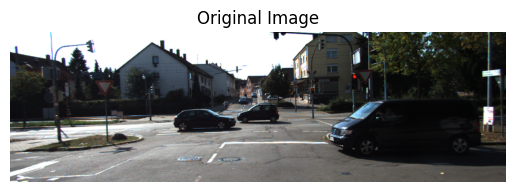

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


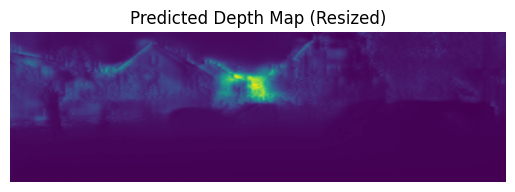

In [13]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os

os.listdir('/kaggle/working')

def preprocess_image(image_path):
    # Define the transformation: resize and convert to tensor
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to match the training input size
        transforms.ToTensor()
    ])
    # Open the image file
    image = Image.open(image_path)
    # Apply the transformation
    image = transform(image)
    # Add batch dimension
    image = image.unsqueeze(0)
    return image

def visualize_depth_map(depth_map, original_size):
    # Resize the depth map to the original image size using torchvision.transforms
    resize_transform = transforms.Resize(original_size[::-1])
    depth_map_resized = resize_transform(torch.tensor(depth_map).unsqueeze(0).unsqueeze(0)).squeeze().numpy()
    # Display the resized depth map using a colormap
    plt.imshow(depth_map_resized, cmap='viridis')
    plt.axis('off')  # Hide axes
    plt.title('Predicted Depth Map (Resized)')
    plt.show()

# Preprocess the input image
image_path = '/kaggle/working/testing/image_2/000043_10.png'

# Open and display the original image using matplotlib
original_image = Image.open(image_path)
original_size = original_image.size  # Save the original image size
plt.imshow(original_image)
plt.axis('off')  # Hide axes
plt.title('Original Image')
plt.show()

# Apply preprocessing to the image
input_image = preprocess_image(image_path)

# Perform inference
with torch.no_grad():
    # Move the input image to GPU
    input_image = input_image.cuda()
    # Predict the depth map using the model
    depth_map = model(input_image)

# Post-process and visualize the depth map
depth_map = depth_map.squeeze().cpu().numpy()
visualize_depth_map(depth_map, original_size)

# Warp a test image 
Using the knowledge and implementations so far, we create a $\hat{I}_s$ for the provided image and plot it.

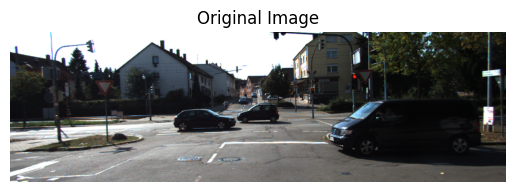

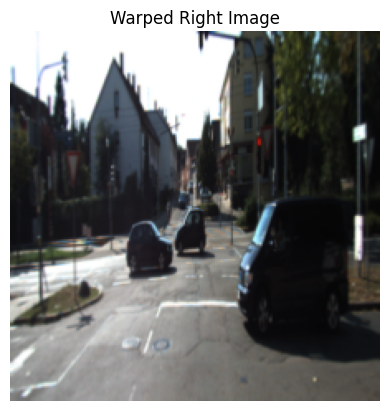

In [14]:
image_path = '/kaggle/working/testing/image_2/000043_10.png'
right_image_path = '/kaggle/working/testing/image_3/000043_10.png'

# Open and display the original image using matplotlib
original_image = Image.open(image_path)
original_size = original_image.size  # Save the original image size
plt.imshow(original_image)
plt.axis('off')  # Hide axes
plt.title('Original Image')
plt.show()

# Apply preprocessing to the image
input_image = preprocess_image(image_path)
input_image_right = preprocess_image(right_image_path)

# Create a dummy inputs dictionary with necessary keys
inputs = {
    "stereo_T": torch.eye(4).unsqueeze(0),  # Example stereo transformation matrix
    "inv_K": torch.eye(3).unsqueeze(0),     # Example inverse camera intrinsics matrix
    "K": torch.eye(3).unsqueeze(0),         # Example camera intrinsics matrix
    "img_right": input_image_right,         # Preprocessed right image
}

# Perform inference
with torch.no_grad():
    # Move the input image to GPU
    input_image = input_image.cuda()
    input_image_right = input_image_right.cuda()
    depth_map = model(input_image)  
    inputs["stereo_T"] = inputs["stereo_T"][:, :3, :].cuda()
    inputs["inv_K"] = inputs["inv_K"].cuda()
    inputs["K"] = inputs["K"].cuda()
    inputs["img_right"] = inputs["img_right"].cuda()

    # Create WarpImage instance
    warp_image_module = WarpImage(batch_size=1, height=224, width=224).cuda()

    # Warp the right image
    warped_image = warp_image_module(inputs, depth_map)

# Convert the warped image to CPU and display it
warped_image_cpu = warped_image.cpu().squeeze(0).permute(1, 2, 0).numpy()
plt.imshow(warped_image_cpu)
plt.axis('off')  # Hide axes
plt.title('Warped Right Image')
plt.show()